# DLANN
## ~~Doesn't Learn Anything Neural Network~~
## Deep Learning Autoencoder Neural Network

Import necessary packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras import backend as K
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, AveragePooling2D, UpSampling2D

### Data

Define core features of the dataset

In [2]:
dim = 2
numpart = 30
box_size = 10
latent_dim = 10

Import and reshape data

In [3]:
fname = r'\\wsl$\Ubuntu\home\alepitte\ale\uni\variational-autoencoders\mc-sampling\dump\test_30_10_1_0.75_0.2_50000_2500_0_x.txt'
#fname="mc-sampling/good-runs/nonpolimero_x.txt"

with open(fname) as f:
    data = [
        [float(i.strip()) for i in s.split(" ") if i != ""]
        for s in f.read().split("\n")
        if s != ""]

In [4]:
print(data[1])

[6.602492, 2.914273, 5.632625, 2.352631, 9.804926, 1.776639, 8.781303, 2.441727, 3.365558, 3.489642, 0.497381, 2.97126, 7.64297, 3.371478, 2.729281, 0.111159, 7.452005, 0.424503, 2.370376, 4.020165, 9.921614, 0.214307, 2.408065, 2.283695, 2.01747, 1.368826, 4.418548, 4.454403, 8.20593, 1.321902, 9.103216, 0.968846, 7.593875, 2.261605, 5.770208, 1.303452, 0.562347, 0.384708, 1.026059, 3.971758, 6.422909, 0.433186, 4.836941, 1.656635, 7.011751, 1.411104, 4.452852, 2.956323, 3.918127, 0.024072, 1.694333, 2.969465, 1.667498, 0.252255, 3.066908, 1.224696, 5.284445, 0.003942, 8.50326, 0.046534]


In [5]:
vcs = np.array(data).reshape((-1,numpart,dim))/box_size
print(vcs.shape)

(50000, 30, 2)


In [6]:
sortmode = 2

In [7]:
if sortmode == 1 :
    idx = np.lexsort((vcs[:,:,0], vcs[:,:,1]))
    
    # Use the indices to sort each step while maintaining the rows intact
    sorted_vcs = np.empty_like(vcs)
    for i in range(len(vcs)):
        sorted_vcs[i] = vcs[i][idx[i]]
            
    print(sorted_vcs.shape,"\n",sorted_vcs[1])

In [8]:
if sortmode==2:

    # Calculate distances from (0, 0)
    distances = np.sqrt(vcs[:,:,0]**2 + vcs[:,:,1]**2)
    idx = np.argsort(distances, axis=1)
    sorted_vcs = np.empty_like(vcs)
    for i in range(len(vcs)):
        sorted_vcs[i] = vcs[i][idx[i]]

    print(sorted_vcs.shape,"\n",sorted_vcs[1])

(50000, 30, 2) 
 [[5.623470e-02 3.847080e-02]
 [1.667498e-01 2.522550e-02]
 [2.017470e-01 1.368826e-01]
 [2.729281e-01 1.111590e-02]
 [4.973810e-02 2.971260e-01]
 [3.066908e-01 1.224696e-01]
 [2.408065e-01 2.283695e-01]
 [1.694333e-01 2.969465e-01]
 [3.918127e-01 2.407200e-03]
 [1.026059e-01 3.971758e-01]
 [2.370376e-01 4.020165e-01]
 [3.365558e-01 3.489642e-01]
 [4.836941e-01 1.656635e-01]
 [5.284445e-01 3.942000e-04]
 [4.452852e-01 2.956323e-01]
 [5.770208e-01 1.303452e-01]
 [5.632625e-01 2.352631e-01]
 [4.418548e-01 4.454403e-01]
 [6.422909e-01 4.331860e-02]
 [7.011751e-01 1.411104e-01]
 [6.602492e-01 2.914273e-01]
 [7.452005e-01 4.245030e-02]
 [7.593875e-01 2.261605e-01]
 [8.205930e-01 1.321902e-01]
 [7.642970e-01 3.371478e-01]
 [8.503260e-01 4.653400e-03]
 [8.781303e-01 2.441727e-01]
 [9.103216e-01 9.688460e-02]
 [9.921614e-01 2.143070e-02]
 [9.804926e-01 1.776639e-01]]


In [9]:
train_perc=0.8
trainset = vcs[:int(train_perc*len(data))]
print(trainset.shape)
test_perc=0.25*train_perc
testset = vcs[int(train_perc*len(data)):int((test_perc+train_perc)*len(data))]
print(testset.shape)

(40000, 30, 2)
(10000, 30, 2)


In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [11]:
#Encoder

encoder_inputs = keras.Input(shape=(numpart, dim, 1))
#x = Conv2D(128, (3,3), padding='same', activation='relu')(encoder_inputs)
#x = AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(encoder_inputs)
#x = AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#x = AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)

x = Flatten()(x)
#x = Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


#decoder
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, (3,3), padding='same', activation='relu')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3,3), padding='same', activation='relu')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2DTranspose(128, (3,3), padding='same', activation='relu')(x)
#x = UpSampling2D((2, 2))(x)
decoder_outputs = Conv2DTranspose(1, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = keras.Model(decoder_input, decoder_outputs, name='decoder')
decoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 2, 1)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 2, 64)    640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 2, 32)    18464       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 1920)         0           ['conv2d_1[0][0]']               
                                                                                            

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
        
            data = tf.expand_dims(data, axis=-1)
            
            reconstruction_loss = tf.reduce_mean(
                 
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
                
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [13]:
#training
reg_lambda = 0.001
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
fit=vae.fit(trainset, epochs=100, batch_size=128, verbose=2)

Epoch 1/100
313/313 - 17s - loss: 34.3682 - reconstruction_loss: 34.3665 - kl_loss: 1.7239 - 17s/epoch - 54ms/step
Epoch 2/100
313/313 - 16s - loss: 32.6344 - reconstruction_loss: 32.6298 - kl_loss: 4.5636 - 16s/epoch - 53ms/step
Epoch 3/100
313/313 - 16s - loss: 32.5121 - reconstruction_loss: 32.5075 - kl_loss: 4.6288 - 16s/epoch - 50ms/step
Epoch 4/100
313/313 - 15s - loss: 32.2428 - reconstruction_loss: 32.2383 - kl_loss: 4.4918 - 15s/epoch - 49ms/step
Epoch 5/100
313/313 - 15s - loss: 31.4259 - reconstruction_loss: 31.4208 - kl_loss: 5.1118 - 15s/epoch - 48ms/step
Epoch 6/100
313/313 - 15s - loss: 31.1513 - reconstruction_loss: 31.1458 - kl_loss: 5.5459 - 15s/epoch - 47ms/step
Epoch 7/100
313/313 - 15s - loss: 31.0138 - reconstruction_loss: 31.0080 - kl_loss: 5.7936 - 15s/epoch - 47ms/step
Epoch 8/100
313/313 - 15s - loss: 30.9300 - reconstruction_loss: 30.9241 - kl_loss: 5.8876 - 15s/epoch - 47ms/step
Epoch 9/100
313/313 - 15s - loss: 30.8511 - reconstruction_loss: 30.8451 - kl_lo

Epoch 72/100
313/313 - 15s - loss: 30.0085 - reconstruction_loss: 30.0011 - kl_loss: 7.3887 - 15s/epoch - 48ms/step
Epoch 73/100
313/313 - 15s - loss: 29.9736 - reconstruction_loss: 29.9662 - kl_loss: 7.3878 - 15s/epoch - 47ms/step
Epoch 74/100
313/313 - 14s - loss: 30.0013 - reconstruction_loss: 29.9938 - kl_loss: 7.4154 - 14s/epoch - 46ms/step
Epoch 75/100
313/313 - 14s - loss: 30.0460 - reconstruction_loss: 30.0386 - kl_loss: 7.4278 - 14s/epoch - 45ms/step
Epoch 76/100
313/313 - 15s - loss: 30.0024 - reconstruction_loss: 29.9949 - kl_loss: 7.4396 - 15s/epoch - 47ms/step
Epoch 77/100
313/313 - 15s - loss: 30.0101 - reconstruction_loss: 30.0026 - kl_loss: 7.4952 - 15s/epoch - 47ms/step
Epoch 78/100
313/313 - 15s - loss: 30.0153 - reconstruction_loss: 30.0078 - kl_loss: 7.4765 - 15s/epoch - 47ms/step
Epoch 79/100
313/313 - 15s - loss: 29.9872 - reconstruction_loss: 29.9798 - kl_loss: 7.4538 - 15s/epoch - 48ms/step
Epoch 80/100
313/313 - 15s - loss: 29.9949 - reconstruction_loss: 29.987

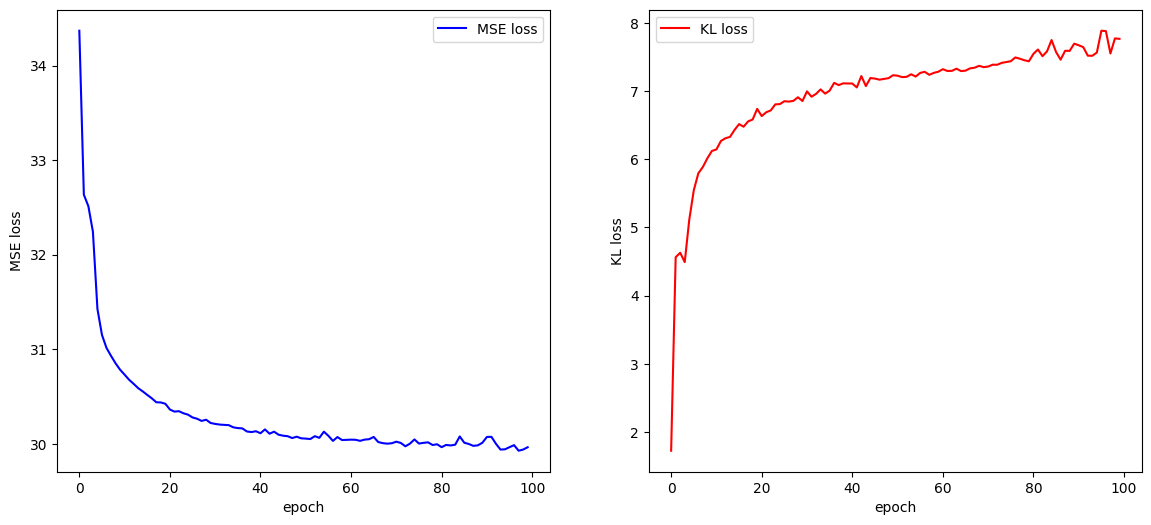

In [14]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['loss'],label="MSE loss",c="b")
ax.set_xlabel('epoch')
ax.set_ylabel("MSE loss")
ax.legend()
ax=AX[1]
ax.plot(fit.history['kl_loss'],label="KL loss",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [15]:
encoded_test = np.array(vae.encoder.predict(testset))

313/313 [==============================] - 2s 5ms/step


In [16]:
print(encoded_test.shape)

(3, 10000, 10)


z_mean are the first dimension, z_log_var the second (used in training), we're interested in the third dimension, which are the sampled z

In [17]:
dim1 = encoded_test[2,:,:]
print(dim1.shape)

(10000, 10)


Sampling in the latent space is reasonably gaussian as expected

In [18]:
#df = pd.DataFrame(dim1, columns=["x", "y"])
#sns.jointplot(x="x", y="y", data=df);

We can now use the data to decode

In [19]:
decoded_test = np.array(decoder.predict(encoded_test[2,:,:])).reshape(-1,numpart,dim)
print(decoded_test.shape)

313/313 [==============================] - 2s 6ms/step
(10000, 30, 2)


#### Check reconstruction

In [20]:
decoded_test[2]

array([[0.27462667, 0.17482306],
       [0.587514  , 0.17756729],
       [0.6658019 , 0.16025987],
       [0.6439375 , 0.16776845],
       [0.44648364, 0.16540387],
       [0.6351591 , 0.17295788],
       [0.8773    , 0.16863813],
       [0.16293249, 0.14721638],
       [0.30311993, 0.18939666],
       [0.58622766, 0.18009204],
       [0.7203723 , 0.162146  ],
       [0.1606947 , 0.16739853],
       [0.51924753, 0.19717854],
       [0.7697383 , 0.18024799],
       [0.63707024, 0.16735524],
       [0.46318492, 0.17928736],
       [0.14686616, 0.17813775],
       [0.6783012 , 0.18916506],
       [0.2840702 , 0.15860134],
       [0.21190162, 0.1482145 ],
       [0.49839738, 0.17094219],
       [0.47439158, 0.17718303],
       [0.11282977, 0.15936401],
       [0.642935  , 0.18354054],
       [0.81299406, 0.17184815],
       [0.08059824, 0.15566535],
       [0.45823896, 0.17799197],
       [0.13072427, 0.16600971],
       [0.79839927, 0.14731716],
       [0.21620391, 0.1521075 ]], dtype=flo

In [21]:
ts = testset.reshape(-1,numpart,dim)
print(ts[2,:,:])

[[2.990644e-01 3.352000e-04]
 [7.735282e-01 2.992800e-03]
 [7.309610e-01 2.924166e-01]
 [8.716311e-01 2.100680e-01]
 [3.298893e-01 9.424160e-02]
 [5.848028e-01 1.206412e-01]
 [9.723777e-01 2.747653e-01]
 [2.482327e-01 2.078027e-01]
 [5.366855e-01 4.675300e-03]
 [4.193797e-01 1.547142e-01]
 [8.979198e-01 2.698030e-02]
 [1.419817e-01 2.895554e-01]
 [6.040007e-01 3.293142e-01]
 [8.141228e-01 1.228458e-01]
 [9.904185e-01 1.237807e-01]
 [4.270444e-01 3.677650e-02]
 [2.075590e-01 9.940480e-02]
 [7.093927e-01 1.337432e-01]
 [2.900636e-01 3.314003e-01]
 [1.262072e-01 1.732292e-01]
 [6.536569e-01 4.198210e-02]
 [4.408216e-01 2.701317e-01]
 [4.005290e-02 2.582971e-01]
 [5.137588e-01 2.021446e-01]
 [8.564943e-01 3.419889e-01]
 [1.160887e-01 4.095560e-02]
 [5.207156e-01 5.226902e-01]
 [2.039200e-03 1.394003e-01]
 [6.289994e-01 2.188384e-01]
 [3.491023e-01 2.361448e-01]]


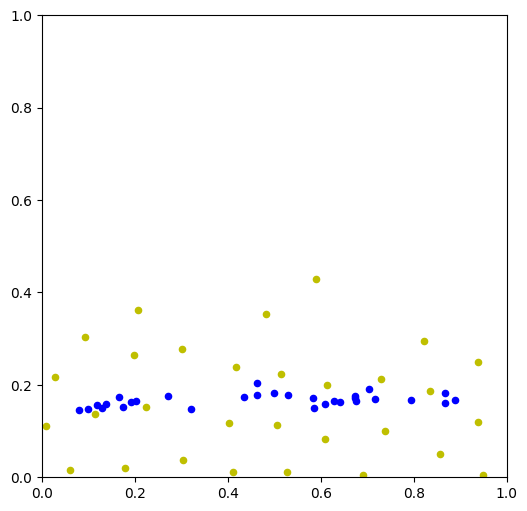

In [22]:
if dim == 2:
    ind = 1
    plt.figure(figsize=(6, 6))
    plt.scatter(decoded_test[ind,:,0], decoded_test[ind,:,1], s=20, c="b")
    plt.scatter(ts[ind,:,0], ts[ind,:,1], s=20, c="y")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

MovieWriter imagemagick unavailable; using Pillow instead.


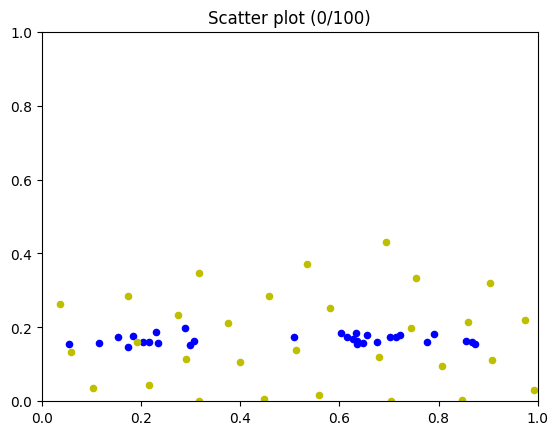

In [23]:
from matplotlib.animation import FuncAnimation

# Create the figure and axis objects
fig, ax = plt.subplots()

nframes = 100

# Define the animation function
def update(ind):
    ax.clear()
    plt.scatter(decoded_test[ind,:,0], decoded_test[ind,:,1], s=20, c="b")
    plt.scatter(ts[ind,:,0], ts[ind,:,1], s=20, c="y")
    ax.set_title(f"Scatter plot ({ind}/{nframes})")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

# Create the animation
animation = FuncAnimation(fig, update, frames=nframes, interval=300)

# Save the animation as a GIF
animation.save("prediction.gif", writer="imagemagick")


In [24]:
if dim ==3:
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(decoded_test[1,:,0], decoded_test[1,:,1],decoded_test[1,:,2], s=30, c="b", depthshade=True)
    ax.scatter(ts[1,:,0], ts[1,:,1],ts[1,:,2], s=30, c="y", depthshade=True)
    ax.view_init(45,45)

1563/1563 [==============================] - 4s 3ms/step
0.16532225655472854 0.1593142357561813 0.32463649231090985


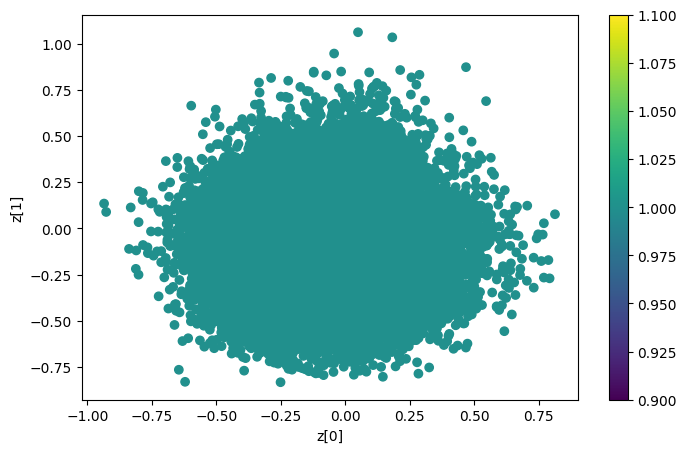

In [25]:
from scipy import linalg as la

labels = [1]*len(data)
def label_vis(vae, data, labels):
    
    #prediction
    z_mean, _, _ = vae.encoder.predict(data)
    
    #PCA on z_mean
    A = pd.DataFrame(z_mean)
    l, V = la.eig(np.cov(A.T))
    lr = np.copy(l.real)
    n1 = np.argmax(l)
    l[n1] = 0
    n2 = np.argmax(l)
    print(lr[n1]/sum(lr), lr[n2]/sum(lr), (lr[n1]+lr[n2])/sum(lr) )

    #plot
    plt.figure(figsize=(8, 5))
    plt.scatter(z_mean[:, n1], z_mean[:, n2], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

label_vis(vae, vcs, labels)